# Laboratorio 2 - Complejidad y búsqueda de hiperparámetros
### Sergio David Ferreira - Juan David Gutierrez


## Librerías utilizadas

In [323]:
import random
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Carga de datos y partición de datos
Para la carga de datos se carga el archivo del laboratorio anterior, se eliminan pacientes duplicados y outliers y valores faltantes sobre la columna target, *CVD Risk Score*

In [324]:
data = pd.read_csv('data/Datos Lab 1.csv')

# Normalizamos fechas
data['Date of Service'] = pd.to_datetime(data['Date of Service'], format='mixed')

# Eliminamos pacientes con registros duplicados manteniendo el más reciente
data = data.sort_values(['Patient ID', 'Date of Service'], ascending=[True, False])
data = data.drop_duplicates(subset='Patient ID', keep='first')

# Eliminamos registros con valores faltantes en el target
data = data.dropna(subset=['CVD Risk Score'])

# Eliminamos registros de outliers en la variable target
q1 = data['CVD Risk Score'].quantile(0.25)
q3 = data['CVD Risk Score'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

data = data[(data['CVD Risk Score'] > limite_inferior) & (data['CVD Risk Score'] < limite_superior)]

#Mostramos un sample de los datos
data.sample(3)

,Patient ID,Date of Service,Sex,Age,Weight (kg),Height (m),BMI,Abdominal Circumference (cm),Blood Pressure (mmHg),Total Cholesterol (mg/dL),HDL (mg/dL),Fasting Blood Sugar (mg/dL),Smoking Status,Diabetes Status,Physical Activity Level,Family History of CVD,Height (cm),Waist-to-Height Ratio,Systolic BP,Diastolic BP,Blood Pressure Category,Estimated LDL (mg/dL),CVD Risk Score,CVD Risk Level
1051,LNth3130,2020-10-30,M,50.0,56.5,1.830,16.900,86.9,118/95,262.0,35.0,NaN,N,Y,Moderate,N,183.000,0.475,118.0,95.0,Hypertension Stage 2,197.0,16.520,HIGH
1350,fJxy1980,2020-02-22,M,31.0,NaN,1.563,19.096,NaN,126/84,265.0,39.0,171.0,Y,Y,High,Y,156.301,0.603,126.0,84.0,Hypertension Stage 1,196.0,17.419,LOW
1555,bArw6042,2025-06-08,F,43.0,115.5,1.880,32.700,74.5,131/68,232.0,62.0,142.0,Y,Y,High,N,188.000,0.396,131.0,68.0,Hypertension Stage 1,140.0,19.730,HIGH


Ahora, separamos los datos en entrenamiento y prueba

In [325]:
target = 'CVD Risk Score'
X = data.drop(columns=[target])
y = data[target]

In [326]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

(1038, 23) (1038,)
(260, 23) (1038,)


## Construcción del pipeline

Para la construcción del pipeline se sigue el procedimiento del laboratorio anterior, por lo tanto únicamente se enuncian los pasos sin añadir justificaciones del proceso.

### Codificación de variables categóricas

In [327]:
numeric_features = [
    "Age", "Weight (kg)", "Height (m)", "Height (cm)", "BMI", "Abdominal Circumference (cm)", 
    "Total Cholesterol (mg/dL)", "HDL (mg/dL)", "Fasting Blood Sugar (mg/dL)", 
    "Waist-to-Height Ratio", "Systolic BP", "Diastolic BP", "Estimated LDL (mg/dL)"
]

ordinal_features = [
    "Physical Activity Level", "Blood Pressure Category"
]

binary_features = [
    "Sex", "Smoking Status", "Diabetes Status", "Family History of CVD"
]

binary_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy=lambda x: random.randint(0, 1)))
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories = [
        ['Low', 'Moderate', 'High'],  # Physical Activity Level
        ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2']  # Blood Pressure Category
    ]))
])


### Eliminación de columnas redundantes o innecesarias

In [328]:
col_drop = ['Blood Pressure (mmHg)', 'Patient ID', 'Date of Service', 'CVD Risk Level']
def drop_columns(df):
    return df.drop(columns=col_drop, errors='ignore')

dropper = FunctionTransformer(drop_columns)

### Manejo de outliers por rangos válidos de las variables

In [329]:
rangos = {
    'Diastolic BP': (40, 125),
    'Systolic BP': (80, 190),
    'Fasting Blood Sugar (mg/dL)': (60, 200),
    'Total Cholesterol (mg/dL)': (80, 320),
    'HDL (mg/dL)': (20, 100),
    'Estimated LDL (mg/dL)': (0, 250),
    'BMI': (15, 50),
    'Weight (kg)': (30, 140),
    'Height (m)': (1.45, 2),
    'Height (cm)': (145, 200),
    'Abdominal Circumference (cm)': (60, 130),
    'Waist-to-Height Ratio': (0.35, 0.8),
    'Age': (18, 100)
}
def limpiar_rangos(df):
    for col, (min_val, max_val) in rangos.items():
        if col in df.columns:
            df.loc[
                (df[col] <= min_val) | (df[col] >= max_val),
                col
            ] = np.nan
    return df
rangos_validos = FunctionTransformer(limpiar_rangos)
numeric_transformer = Pipeline(steps=[
    ('rangos', rangos_validos)
])

### Imputación de valores faltantes
Variables sin multicolinealidad

In [330]:
clean_numeric_data = numeric_transformer.fit_transform(X_train)
clean_numeric_data = pd.DataFrame(clean_numeric_data, columns=numeric_features)

median_columns = ['Age', 'Diastolic BP', 'Systolic BP', 'Fasting Blood Sugar (mg/dL)', 'HDL (mg/dL)']
mean_columns = ['Weight (kg)', 'BMI']
median_transformer = SimpleImputer(strategy='median')
mean_transformer = SimpleImputer(strategy='mean')
simple_imputer_transformer = ColumnTransformer(transformers=[
    ('median', median_transformer, median_columns),
    ('mean', mean_transformer, mean_columns)
])

Variables con alta colinealidad

In [331]:
class MiImputador(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.k = {}
        # Waist to height ratio
        self.k['Waist-to-Height Ratio'] = \
            (X['Waist-to-Height Ratio'] / X['Abdominal Circumference (cm)']).dropna().median()

        # Abdominal circumference
        self.k['Abdominal Circumference (cm)'] = \
            (X['Abdominal Circumference (cm)'] / X['Waist-to-Height Ratio']).dropna().median()

        # Total cholesterol
        self.k['Total Cholesterol (mg/dL)'] = \
            (X['Total Cholesterol (mg/dL)'] / X['Estimated LDL (mg/dL)']).dropna().median()

        # Estimated LDL
        self.k['Estimated LDL (mg/dL)'] = \
            (X['Estimated LDL (mg/dL)'] / X['Total Cholesterol (mg/dL)']).dropna().median()
        
        return self

    def transform(self, X):
        temp_abdominal = \
            X['Abdominal Circumference (cm)'].fillna(X['Abdominal Circumference (cm)'].mean())
        X['Waist-to-Height Ratio'] = \
            X['Waist-to-Height Ratio'].fillna(self.k['Waist-to-Height Ratio'] * temp_abdominal)
        X['Abdominal Circumference (cm)'] = \
            X['Abdominal Circumference (cm)'].fillna(self.k['Abdominal Circumference (cm)'] * X['Waist-to-Height Ratio'])
        
        temp_ldl = X['Estimated LDL (mg/dL)'].fillna(X['Estimated LDL (mg/dL)'].mean())
        X['Total Cholesterol (mg/dL)'] = \
            X['Total Cholesterol (mg/dL)'].fillna(self.k['Total Cholesterol (mg/dL)'] * temp_ldl)
        X['Estimated LDL (mg/dL)'] = X['Estimated LDL (mg/dL)'].fillna(self.k['Estimated LDL (mg/dL)'] * X['Total Cholesterol (mg/dL)'])

        temp_height = X['Height (m)'].fillna(X['Height (m)'].mean())
        X['Height (cm)'] = X['Height (cm)'].fillna(temp_height * 100)
        X['Height (m)'] = X['Height (m)'].fillna(X['Height (cm)'] / 100)
        
        return X

corr_imputer = MiImputador()
corr_features = ['Waist-to-Height Ratio', 'Abdominal Circumference (cm)', 'Total Cholesterol (mg/dL)', 'Estimated LDL (mg/dL)', 'Height (cm)', 'Height (m)']
imputer_transformer = ColumnTransformer(transformers=[
    ('simple', simple_imputer_transformer, median_columns + mean_columns),
    ('correlated', corr_imputer, corr_features)
])
numeric_transformer.steps.append(('imputer', imputer_transformer))

### Eliminación de variables con alta multicolinealidad

In [332]:
columns_vif=['Height (cm)', 'Waist-to-Height Ratio', 'Estimated LDL (mg/dL)', 'Blood Pressure Category']
def drop_high_vif(df):
    f_names = median_columns + mean_columns + corr_features
    df = pd.DataFrame(df, columns=f_names)
    return df.drop(columns=columns_vif, errors='ignore')
dropper_vif = FunctionTransformer(drop_high_vif)
numeric_transformer.steps.append(('dropper_vif', dropper_vif))

### Escalado MinMax

In [333]:
numeric_transformer.steps.append(('scaler', MinMaxScaler()))

### Construcción del pipeline final

In [334]:
numeric_transformer.steps.append(('polynomial', PolynomialFeatures(degree=1)))
preprocessing_transformer = ColumnTransformer(transformers=[
    ('binary', binary_transformer, binary_features),
    ('ordinal', ordinal_transformer, ordinal_features),
    ('numeric', numeric_transformer, numeric_features)
])
pipeline_regresion = Pipeline(steps=[
    ('dropper', dropper),
    ('preprocesamiento', preprocessing_transformer),
    ('modelo', LinearRegression())
])

## Comparación y selección de modelos
Para evaluar distintos modelos de regresión polinomial aplicamos transformación de variables polinomiales al transformador numérico, para después ajustarlo a un modelo de regresión lineal. Evaluaremos modelos de hasta cuarto grado.

In [335]:
param_grid = {
    "preprocesamiento__numeric__polynomial__degree": list(range(1,5)),
    "preprocesamiento__numeric__scaler": [
        MinMaxScaler(),
        Pipeline([
            ('log', FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)),
            ('scaler', StandardScaler())
        ]),
        None
    ],
}

scoring = {
    "MSE": "neg_mean_squared_error",
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}

In [336]:
grid = GridSearchCV(
    estimator=pipeline_regresion,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='RMSE',
    return_train_score=True,
    n_jobs=-1
)

In [337]:
%%time
grid.fit(X_train, y_train)

CPU times: total: 703 ms
Wall time: 2.62 s


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'preprocesamiento__numeric__polynomial__degree': [1, 2, ...], 'preprocesamiento__numeric__scaler': [MinMaxScaler(), Pipeline(step...ardScaler())]), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error', 'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'RMSE'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-f

In [338]:
resultados = pd.DataFrame(grid.cv_results_)
resultados = resultados.rename(columns={
    'param_preprocesamiento__numeric__scaler': 'Scaler',
    'param_preprocesamiento__numeric__polynomial__degree': 'Degree',
})
resultados[[
    "Scaler",
    "Degree",
    "mean_test_MSE",
    "mean_test_RMSE",
    "mean_test_MAE",
    "mean_test_R2"
]].sort_values("mean_test_MSE", ascending=False)

,Scaler,Degree,mean_test_MSE,mean_test_RMSE,mean_test_MAE,mean_test_R2
0,MinMaxScaler(),1,-0.425680,-0.620213,-0.261020,0.933257
2,None,1,-0.425680,-0.620213,-0.261020,0.933257
4,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",2,-0.451771,-0.641367,-0.295757,0.929011
5,None,2,-0.456702,-0.645988,-0.304257,0.928215
3,MinMaxScaler(),2,-0.456702,-0.645988,-0.304257,0.928215
1,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",1,-0.567378,-0.718283,-0.406117,0.911231
6,MinMaxScaler(),3,-0.695414,-0.821919,-0.493288,0.889511
8,None,3,-0.695414,-0.821919,-0.493288,0.889511
7,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",3,-0.741202,-0.846729,-0.507672,0.882629
10,"(FunctionTransformer(func=<ufunc 'log1p'>, inv...",4,-42.636536,-6.289854,-3.768557,-5.801835


In [339]:
print("Mejor configuración:", grid.best_params_)

Mejor configuración: {'preprocesamiento__numeric__polynomial__degree': 1, 'preprocesamiento__numeric__scaler': MinMaxScaler()}


In [340]:
grados = list(range(1,5))
train_scores, val_scores = validation_curve(
    estimator=pipeline_regresion,
    X=X_train,
    y=y_train,
    param_name="preprocesamiento__numeric__polynomial__degree",
    param_range= grados,
    cv=5,
    scoring="neg_mean_squared_error"
)

train_mean = -np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)

val_mean = -np.mean(val_scores, axis=1)
val_std  = np.std(val_scores, axis=1)

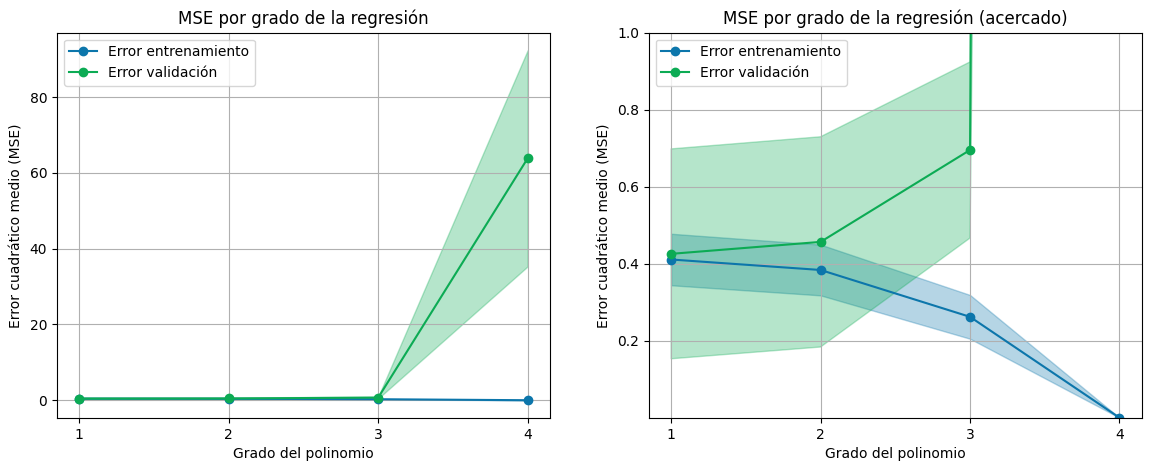

In [353]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
for i in range(1,3):
    plt.subplot(1,2,i)
    plt.plot(grados, train_mean, label="Error entrenamiento", marker="o", color="#0c76ab")
    plt.fill_between(
        grados,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.3,
        color="#0c76ab"
    )

    plt.plot(grados, val_mean, label="Error validación", marker="o", color="#0cab54")
    plt.fill_between(
        grados,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.3,
        color="#0cab54"
    )
    plt.xlabel("Grado del polinomio")
    plt.xticks(range(1,5))
    plt.ylabel("Error cuadrático medio (MSE)")
    title = 'MSE por grado de la regresión'
    if i == 2:
        plt.ylim([1e-5, 1])
        title += ' (acercado)'
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.show()

In [342]:
mejor_modelo = pipeline_regresion.fit(X_train, y_train)
y_test_pred = mejor_modelo.predict(X_test)
print(f'------ Mejor modelo - Resultados en test ----')
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f'R²: {r2_score(y_test, y_test_pred):.2f}')

------ Mejor modelo - Resultados en test ----
RMSE: 0.81
MAE: 0.31
R²: 0.90


In [343]:
# Usamos 'neg_mean_squared_error' porque sklearn busca maximizar puntajes
# Lo multiplicamos por -1 para tener el MSE real
scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores

print(f"MSE promedio: {mse_scores.mean():.4f}")
print(f"Desviación Estándar del MSE: {mse_scores.std():.4f}")
print(f"Intervalo de confianza (aprox): [{mse_scores.mean() - 2*mse_scores.std():.4f}, {mse_scores.mean() + 2*mse_scores.std():.4f}]")

MSE promedio: 0.4257
Desviación Estándar del MSE: 0.2726
Intervalo de confianza (aprox): [-0.1195, 0.9708]
